In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing
import os
save_dir = os.path.join(os.getcwd(),'save_model')

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 64    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
len(train)

118562

In [4]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        current_vid=0
        X_tr_array = np.zeros([batch_size,nb_frames,img_cols,img_rows,channels])
        Y_train = np.zeros([batch_size, nb_classes])
        for vid_ID in random.sample(train_list,batch_size):
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                pos = os.path.join(pos_dir,img_ID)
                neg = os.path.join(neg_dir,img_ID)
                p_img = cv2.imread(pos,0)
                n_img = cv2.imread(neg,0)
                frame = cv2.merge((p_img,n_img))
                X_tr_array[current_vid,frame_count]=frame
                frame_count+=1
            Y_train[current_vid]=np_utils.to_categorical(labels_dict[vid_ID], nb_classes)
            current_vid+=1

        yield X_tr_array,Y_train

In [5]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 64, 100, 176, 2)


In [6]:
# Define model
import tensorflow as tf
keras=tf.contrib.keras
l2=keras.regularizers.l2
weight_decay = 0.00005
from keras import regularizers

model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_1'))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_1'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), name='MaxPool_1'))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_2'))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_2'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), name='MaxPool_2'))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_3'))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_3'))
model.add(MaxPooling3D(pool_size=(1, 1, 4 ), name='MaxPool_3'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='LSTM_1'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='LSTM_2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='LSTM_3'))


model.add(Flatten(name='Flatten'))
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='FC_1'))
model.add(Dropout(0.5, name='Dropout_1'))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='FC_2'))
model.add(Dropout(0.5, name='Dropout_2'))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay), name='FC_3'))

model.add(Activation('softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
Conv_spatial_1 (Conv3D)      (None, 64, 46, 84, 8)     408       
_________________________________________________________________
Conv_temporal_1 (Conv3D)     (None, 60, 46, 84, 8)     328       
_________________________________________________________________
MaxPool_1 (MaxPooling3D)     (None, 60, 23, 42, 8)     0         
_________________________________________________________________
Conv_spatial_2 (Conv3D)      (None, 60, 19, 38, 32)    6432      
_________________________________________________________________
Conv_temporal_2 (Conv3D)     (None, 58, 19, 38, 32)    3104      
_________________________________________________________________
MaxPool_2 (MaxPooling3D)     (None, 29, 9, 19, 32)     0         
__________

In [4]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "deep_full"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [9]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [10]:
nb_epoch = 60
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(16*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/150
231/231 [==============================] - 825s 4s/step - loss: 3.4810 - acc: 0.0851 - val_loss: 3.3661 - val_acc: 0.1150

Epoch 00001: val_acc improved from -inf to 0.11496, saving model to E:\Jupyter\Project\save_model\deep_full
Epoch 2/150
231/231 [==============================] - 790s 3s/step - loss: 3.4132 - acc: 0.0962 - val_loss: 3.3113 - val_acc: 0.1317

Epoch 00002: val_acc improved from 0.11496 to 0.13170, saving model to E:\Jupyter\Project\save_model\deep_full
Epoch 3/150
231/231 [==============================] - 814s 4s/step - loss: 3.3040 - acc: 0.1251 - val_loss: 3.1901 - val_acc: 0.1417

Epoch 00003: val_acc improved from 0.13170 to 0.14174, saving model to E:\Jupyter\Project\save_model\deep_full
Epoch 4/150
231/231 [==============================] - 783s 3s/step - loss: 3.1919 - acc: 0.1542 - val_loss: 3.1037 - val_acc: 0.1842

Epoch 00004: val_acc improved from 0.14174 to 0.18415, saving model to E:\Jupyter\Project\save_model\deep_full
Epoch 5/150
231/231

Epoch 40/150
231/231 [==============================] - 820s 4s/step - loss: 1.9799 - acc: 0.4536 - val_loss: 1.8909 - val_acc: 0.4788

Epoch 00040: val_acc did not improve from 0.50000
Epoch 41/150
231/231 [==============================] - 809s 4s/step - loss: 2.0001 - acc: 0.4514 - val_loss: 1.8204 - val_acc: 0.5100

Epoch 00041: val_acc improved from 0.50000 to 0.51004, saving model to E:\Jupyter\Project\save_model\deep_full
Epoch 42/150
231/231 [==============================] - 792s 3s/step - loss: 1.9616 - acc: 0.4574 - val_loss: 1.8571 - val_acc: 0.4855

Epoch 00042: val_acc did not improve from 0.51004
Epoch 43/150
231/231 [==============================] - 810s 4s/step - loss: 1.9641 - acc: 0.4612 - val_loss: 1.8488 - val_acc: 0.4877

Epoch 00043: val_acc did not improve from 0.51004
Epoch 44/150
231/231 [==============================] - 810s 4s/step - loss: 1.9230 - acc: 0.4739 - val_loss: 1.9570 - val_acc: 0.4632

Epoch 00044: val_acc did not improve from 0.51004
Epoch 45/

KeyboardInterrupt: 

In [ ]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

In [ ]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""

In [ ]:
import pickle
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deeploss_tr.pkl','wb') as fid:
    pickle.dump(training_loss, fid)
with open('E:/Jupyter/Project/save_model/deeploss_val.pkl','wb') as fid:
    pickle.dump(val_loss, fid)
"""with open('deeploss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)"""

In [ ]:

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deepacc_tr.pkl','wb') as fid:
    pickle.dump(training_acc, fid)
with open('E:/Jupyter/Project/save_model/deepacc_val.pkl','wb') as fid:
    pickle.dump(val_acc, fid)

In [5]:
from keras.models import Model, load_model
model1_name = "deep_full"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

In [159]:
n=17

In [ ]:
# Training data
num_samples = 60
X_tr_array = np.zeros([num_samples,nb_frames,img_cols,img_rows,channels])
Y_train = np.zeros([num_samples, nb_classes])

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images_timeSampled")

asdf=0
for vid_ID in tqdm(validation["Video"].tolist()[n*num_samples:(n+1)*num_samples]):
    frame_count=0
    pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
    neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            X_tr_array[asdf,frame_count]=frame
            frame_count+=1
        else:
            break
    Y_train[asdf]=np_utils.to_categorical(labels_dict[vid_ID], nb_classes)
    asdf+=1

 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:03<00:02, 11.68it/s]

In [ ]:
def data_predict_gen(train_list, batch_size=64):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in train_list[n*batch_size:(n+1)*batch_size]:
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [ ]:
#test_pred =model1.predict_generator(train_set[50:70])
#result = np.argmax(test_pred, axis =1)
#print(result)

In [ ]:
from sklearn.metrics import confusion_matrix
met1 = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict_generator(data_predict_gen(validation["Video"].tolist()[0:],60),1),axis =1))
print(met)
print(met1.shape)

In [ ]:
for x in range(met1.shape[0]):
    for y in range(met1.shape[0]):
        met[x][y]=met[x][y]+met1[x][y]

In [25]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(10, 19))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

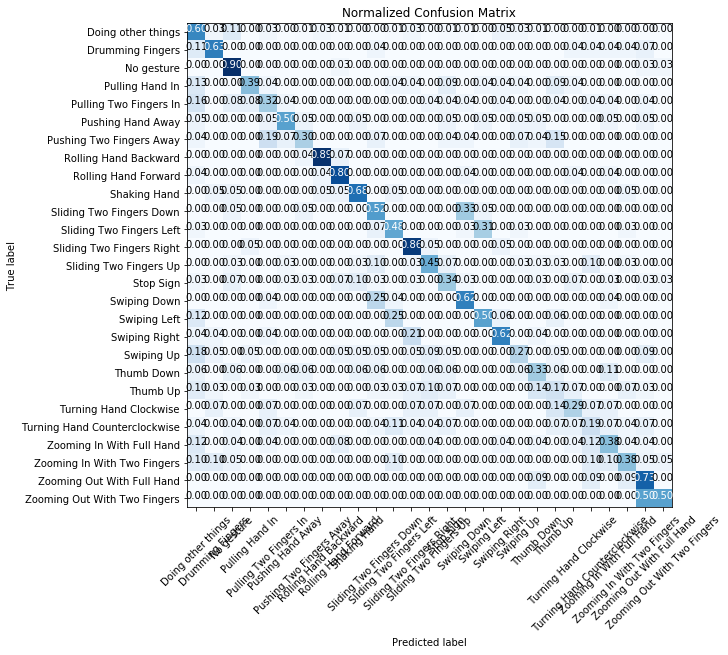

In [122]:
confusion_matrix_plot(met, classes=labels.sort_values(by=['Label'])['Class'].tolist())

In [ ]:
model.evaluate_generator(data_gen(validation["Video"].tolist()[0:],batch_size),
                         len(validation["Video"].tolist()[0:])//(batch_size))

In [9]:
batch_size=64
model1.evaluate_generator(data_gen(validation["Video"].tolist()[0:],batch_size),
                         len(validation["Video"].tolist()[0:])//(16*batch_size))

[1.75426880802427, 0.53125]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

layer_outputs = [layer.output for layer in model1.layers[:12]]
activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations=activation_model.predict(train_set[50:51])
print(train_set[50:51].shape)
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(train_set[50:51].shape[1]):
    im = plt.imshow(train_set[50:51][0, i, :,:, 0], cmap='viridis')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('input' + '.mp4')

layer_num = 0
layer_names=[]
for layer in model1.layers[:15]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):

    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    print(layer_activation.shape,layer_name)
    if layer_num<10:
        for i in range(layer_activation.shape[1]):
            im = plt.imshow(layer_activation[0, i, :,:, 0], cmap='viridis')
            ims.append([im])
     
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('activation' + str(layer_num) + layer_name + '.mp4')
        layer_num +=1